# SNAP UTILIZATION Classification by Socio Economic Features
## Author: Liana Principe

Index of Topics
#### Data Cleaning and Organization   
- [Null Values](#null_values) <br>
- [Feature Selection: Decision Trees](#feature_selection_decision_tree) <br>
- [Splitting and Scaling](#split_scale) <br>
- [Feature Selection: PCA](#feature_selection_pca) <br> 
#### Preliminary Model Testing
- [Logistic Regression](#statsmodel_logistic_regression)<br>
        - Unscaled <br>
        - Scaled <br>
        - PCA <br>
        - Model Comparison
 
#### Hyperparameter Optimization
- [Linear GridSearchCV](#linear_hyperparameter_optimization) <br>
        - Logistic Regression <br>
        - SVM <br>
- [Non-linear GridSearch CV](#nonlinear_hyperparameter_optimization) <br>
        - Boosted Random Forest <br>

#### Model Building
- [Optimized Model Assessment](#model_assessment)
- [Threshold Tampering](#threshold_tampering)
- [Final Training Model](#final_model_analysis)
#### Final Testing and Results

- [Final Testing](#final_test)
- [Feature Importance](#final_feature_importance)
    
    
##### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly as pt
from sklearn.model_selection import train_test_split
import data_processing
import model

import warnings
warnings.filterwarnings('ignore')

C:\Users\liana.principe\Anaconda3\envs\ensemble\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


##### Import Data

In [3]:
all_df = pd.read_csv('C:/Users/liana.principe/OneDrive - insidemedia.net/Documents/Coding & Portfolio/Bootcamp/Capstone Project/faps_household_puf (2).csv', index_col = 'hhnum')

reference_file = pd.read_csv('C:/Users/liana.principe/OneDrive - insidemedia.net/Documents/Coding & Portfolio/Bootcamp/Capstone Project/SNAPHH_column_reference.csv')

snap_target = reference_file['Target_variables'].loc[reference_file['Target_variables'].notnull()]
socio_economic = reference_file['Socio_economic'].loc[reference_file['Socio_economic'].notnull()]
food_support = reference_file['Food_support'].loc[reference_file['Food_support'].notnull()]
nutrition_survey = reference_file['Nutrition_survey'].loc[reference_file['Nutrition_survey'].notnull()]
food_security_survey = reference_file['Food_security_survey'].loc[reference_file['Food_security_survey'].notnull()]
shopping_survey = reference_file['Shopping_survey'].loc[reference_file['Shopping_survey'].notnull()]
snap_variables = reference_file['SNAP_variables'].loc[reference_file['SNAP_variables'].notnull()]
discard_cols =reference_file['Discard_variables'].loc[reference_file['Discard_variables'].notnull()]

pd.options.display.max_rows = 300
pd.options.display.max_columns = 300
divider = '='*80

The document is read into jupyter notebook with a reference file that separates and consolidates the variables into specific lists. This is included for easier organization of variable categories.

Snap Target = the variables of interest in this study. Comprised of household SNAP benefit receivers at various time periods (currently, recently, or ever)

Socio-Economic = features of a household that reveal insight to the social or economic status of the Household. This will be the foundation of features of interest used for the model

Food Support = Reveals information of household usage of alternative food support resources (WIC, food pantries, etc). Although informative, this information is separated because there is a chance of high correlation with the target dependent variable. As such these are put in an individual column to be included or excluded with ease according to the needs of this study.

Nutrition Survey = Nutrition Survey results that are included in the dataset. These are separated from the foundational features of interest because this information may be beneficial as an addition, but is not always gauranteed to be provided. As such, it is consolidated to it's own section to be included and excluded in an easier manner.

Food Security Survey = Food Security Survey results from respondents in the ERS survey. While this is informative

Shopping Survey = Exluded because this information is not likely available in the real world

SNAP Variables = SNAP administrative data that will be exluded from the logistic model due to data leakage with the ideology that rows with non-NaN values in these columns are heavily correlated if not directly to those experiencing food insecurity. These variables are likely expected to introduce data leakage

Discarded Variables: These are variables that will not be considered in this study due to irrelevance, data leakage, or other reasons. Some of these variables are inputed for the survey administration team which is important for organization of the data in the dataset, but pose no meaning for model building. Within the data, there are two granularities of data calculation: one at the household level and one at the family level. This research is following the data at the household level, but the family level data is exlucded to prevent confusion in the model. Lastly, other variables are excluded due to irrelevance of the model or question that leads this research.

Further details of the variables can be seen in the documentation

### Target Variable
Because this portion of the study focuses on survey respondents who have utilized SNAP benefits, the target variable in this study will be `snapnowhh`, which classifies whether or not a household has used SNAP resources in the alloted time of data collection. One thing to note is that this differs from SNAP eligibility status in the event that a household meets the eligibility requirements for SNAP but does not utilize the resources. 


## Data Cleaning and Organization

For ease of convenience and repeptition in this study, a function was created to automate the data cleaning and organizatoin into a specific format. A summary of the cleaning process is described below:
- Re-coding survey administrative data
- Removing any rows where values in the target variable are undefined
- One hot encoding:converting all columns to numerical data type
- Identifying columns and rows that contain nulls

The exact details of the function can be seen in the `data_processing.py` file.

In [4]:
#Organized data (contains nulls)
x,y, df, nulls_df = data_processing.SNAP_clean(all_df, socio_economic, 'snapnowhh')
print(f'''Full Dataframe Shape: {df.shape}
X Shape: {x.shape}
Y Shape: {y.shape}''')

display(df.head())
nulls_df

Full Dataframe Shape: (4824, 95)
X Shape: (4824, 94)
Y Shape: (4824,)


,nonmetro,region,rural,hhsize,numguests,guestspay,hhsizechange,hhsizechild,hhsizemove,hhsizechangeoth,pctpovguidehh_r,inchhreported_r,selfemployhh,selfemployfoodhh,jobchangeany,jobchangecat,earnlessnum_r,earnmorenum_r,earnsamenum,housingown,housingpub,housingsub,liqassets,anyvehicle,vehiclenum,caraccess,largeexp,exprentmrtg_r,exphomeins_r,expproptax_r,exppubtrans_r,expelectric_r,expheatfuel_r,expwastedisp_r,exphealthins_r,expcopay_r,expdoctor_r,exprx_r,expchildcare_r,expchildsupport_r,expadultcare_r,schservebrkfst,anypregnant,primstoredist_s,primstoredist_d,primstoretime_d,primstoredist_w,primstoretime_w,primstoretravelmode,primstoretravelcost,primstoretraveltime,altstoredist_s,altstoredist_d,altstoretime_d,altstoredist_w,altstoretime_w,foodstorenum,shopconv,shopbigbox,shopclub,shopdollar,shopbakery,shopmeatfish,shopvegstand,shopanyother,shopothnone,gardenown,gardenelse,farmersmarket,huntfish,anyvegetarian,anylactoseintol,anyfoodallergy,allergywheat,allergymilk,allergyegg,allergyfish,allergyshellfish,allergycorn,allergypeanut,allergyothnut,allergysoy,allergyoth,anydieting,anytobacco,anyillness,billpayprob6mos,evicted6mos,utilnotpaid6mos,cashadv6mos,paydayloan6mos,ndinnersouthh,nmealshome,nmealstogether,snapnowhh
hhnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100012,1,3,1,5,0,0,0,0,0,0,207.360092,4667.330078,0,0,1,1,0,0,1,1,0,0,1,1,2,0,0,500.0,0.0,0.0,0.0,289.0,0.0,17.0,411.670013,0.0,0.0,18.0,0.0,0.0,0,1,0,0.327,0.682,2.37,0.662,12.450000,1,0.0,4,0.857,1.455,7.80,1.444,28.77,5,1,1,0,1,1,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,9,2,1
100015,0,3,0,1,0,0,0,0,0,0,128.916748,1200.000000,1,0,0,0,0,0,0,1,1,0,1,1,1,0,0,290.0,0.0,0.0,0.0,88.0,0.0,0.0,98.000000,20.0,0.0,125.0,0.0,0.0,0,0,0,1.042,1.352,7.38,0.000,0.000000,1,0.0,5,0.000,0.000,0.00,0.000,0.00,5,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0
100024,0,2,0,2,0,0,0,0,0,0,398.506287,5024.500000,0,0,1,1,0,1,0,1,0,0,1,1,2,0,0,1125.0,13.0,0.0,0.0,125.0,50.0,49.0,300.000000,0.0,0.0,65.0,0.0,0.0,0,1,0,0.895,1.208,3.77,1.195,23.780001,1,0.0,3,1.968,2.397,6.73,0.000,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2,0
100026,0,3,1,2,1,0,0,0,0,0,142.762726,1800.000000,0,0,0,0,0,0,0,2,0,0,1,1,1,0,1,0.0,0.0,0.0,0.0,132.0,0.0,0.0,166.830002,80.0,100.0,150.0,0.0,0.0,0,0,0,1.715,4.358,9.98,0.000,0.000000,1,0.0,5,1.714,4.357,9.98,0.000,0.00,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,2,7,21,0
100028,0,1,0,7,0,0,1,0,1,0,137.348984,3998.000000,0,0,1,1,1,0,0,1,0,0,1,1,1,0,0,475.0,0.0,0.0,0.0,86.0,70.0,100.0,31.000000,0.0,0.0,3.0,0.0,0.0,0,0,0,1.246,1.548,4.23,0.000,0.000000,1,0.0,15,2.383,3.019,7.57,0.000,0.00,5,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,7,3,1


,nulls
altstoredist_s,26
altstoredist_d,26
altstoretime_d,26
altstoredist_w,26
altstoretime_w,26


## Null Values<a id= 'null_values'> </a>

During the data cleaning and organizations, it is shown that there are 26 null rows in 5 columns, all related to the alternative store data. For this section of the research, the rows with null values are removed.
There are a few different ways to account for the missing information

- Method 1: Delete the rows with missing data (26 rows comprised of SNAP and Non-SNAP households)
- Method 2: Delete the columns with missing data (all alternative store info)
- Method 3: Impute the missing values with the mean of each column, depending on if they are a SNAP household or not
        
        - Calculate the alternative store distance for SNAP households and Non-SNAP households
        - Insert these means in the row values depending on if are SNAP or Non-SNAP household
        
        
The last option becomes trickier since some of the survey responses are labeled as -1 and will bring down the average. For the purpose of this section, the rows that contain null values in any of the above columns will be removed. 

#### Method 1: Delete Nan rows

In [5]:
x_cleaned, y_cleaned, df_cleaned = data_processing.delete_nans(df, 'snapnowhh', 0)
print(f'''Cleaned Dataframe Shape: {df_cleaned.shape}
Cleaned X Shape: {x_cleaned.shape}
Cleaned Y Shape: {y_cleaned.shape}''')

Cleaned Dataframe Shape: (4798, 95)
Cleaned X Shape: (4798, 94)
Cleaned Y Shape: (4798,)


Removing the rows with null values leaves 4798 rows in the dataset with 96 features in total, including the target variable. The code below investigates the target variable a little more closely. 

In [73]:
print(f"Count of Outputs\n{df_cleaned['snapnowhh'].value_counts()}\n{divider}\nPercentage of Outputs\n{df_cleaned['snapnowhh'].value_counts(normalize = True)*100}")

Count of Outputs
0    3224
1    1574
Name: snapnowhh, dtype: int64
Percentage of Outputs
0    67.194664
1    32.805336
Name: snapnowhh, dtype: float64


Out of the non-null dataset, 32.8% of survey respondents used SNAP resources. When building the model, this metric will serve as the baseline for how predictive the model should be. Any model with predictive power less than this would be considered no better than manualy guessing by human power.

## Feature Selection: Decision Trees<a id = 'feature_selection_decision_tree'> </a>

In [6]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state = 1)

After removing null values, the next step was to run the non-null dataframe into a Decision Tree for feature selection. For each iteration of the funciton, a Decision Tree was created for all the features in the dataset. Once fitted, the model identifies any features that were insignificant or had a feature importance of 0 when determining the target variable of SNAP benefit usage. For future use of the model, insignificant features or features that are not necessary for SNAP utilization detection will be removed for ease of model building in the rest of this study. These features are identified, recorded, and dropped from the dataset. Then another iteration of the function is run to search for any other insignificant features.

Decision Trees do not need to be scaled and because this is being run as a preliminary feature selection, it does not need to be split into test or train. As such, the original cleaned data will be the input into the Decision Tree below. <br>
Inputs: `x_cleaned`  `y_cleaned`

In [7]:
DecisionTree_feature_selection_dict = {}
#Iteration 1
variables_remove_1=data_processing.feature_selection_dt(dt_model, x_cleaned, y_cleaned)
DecisionTree_feature_selection_dict['Iteration 1']= variables_remove_1

94 Columns Originally 
8 Discard Variables



In [8]:
#Iteration 2
iteration_x2= x_cleaned.drop(columns = variables_remove_1)
variables_remove_2 =data_processing.feature_selection_dt(dt_model, iteration_x2, y_cleaned)
DecisionTree_feature_selection_dict['Iteration 2']= variables_remove_2

86 Columns Originally 
2 Discard Variables



In [9]:
#Iteration 3
iteration_x3= iteration_x2.drop(columns = variables_remove_2)
variables_remove_3 =data_processing.feature_selection_dt(dt_model, iteration_x3, y_cleaned)
DecisionTree_feature_selection_dict['Iteration 3']= variables_remove_3

84 Columns Originally 
1 Discard Variables



In [10]:
#Iteration 4
iteration_x4= iteration_x3.drop(columns = variables_remove_3)
variables_remove_4 =data_processing.feature_selection_dt(dt_model, iteration_x4, y_cleaned)
DecisionTree_feature_selection_dict['Iteration 4']= variables_remove_4

83 Columns Originally 
0 Discard Variables



,feature,importance
7,pctpovguidehh_r,0.322161
27,expelectric_r,0.044893
30,exphealthins_r,0.040298
8,inchhreported_r,0.040186
38,primstoredist_s,0.038270
23,exprentmrtg_r,0.034361
33,exprx_r,0.023379
18,liqassets,0.020601
3,hhsize,0.020095
40,primstoretime_d,0.018290


In [11]:
X_feature_selection = iteration_x4.copy()

 Below is a summary of all the variables that were removed in each iteration of the Decision Tree Process

In [12]:
display(DecisionTree_feature_selection_dict)

{'Iteration 1': ['hhsizechangeoth',
  'jobchangeany',
  'allergymilk',
  'allergyfish',
  'allergycorn',
  'allergypeanut',
  'allergyothnut',
  'allergysoy'],
 'Iteration 2': ['hhsizechild', 'expadultcare_r'],
 'Iteration 3': ['hhsizemove'],
 'Iteration 4': []}

When there are no other insignificant features in the dataset (all features have a feature importance > 0), the function will display the remianing list of features. These features will move on future stages of model building. With the current dataset the study has, 4 iterations of the functions were required to reduce feature size from the original 98 features down to 83 columns.

While all features have an importance greater than 0, that is not to say that that significance is large. In other words, some of the features have a significance that is marginally larger than the set threshold of 0. The likelihood of these features to offer no additional significance will be present in the model biulding stage and will be removed at that time.

## Splitting and Scaling <a id = 'split_scale'> </a>

In [13]:
from sklearn.preprocessing import StandardScaler,  MinMaxScaler

To further prepare for model building, the results from the feature selection will be split into a test and trains and caled as best practice for model learning. <br>
Inputs: `X_feature_selection`, `y_cleaned`

In [14]:
#SPLITTING the data from important features of decision tree
X_train, X_test, y_train, y_test = train_test_split( X_feature_selection, y_cleaned, test_size=0.2, random_state=1)

# SCALING the data
scale= MinMaxScaler().fit(X_train)
X_train_scaled = scale.transform(X_train)
X_test_scaled = scale.transform(X_test)

## Feature Selection: PCA<a id = 'feature_selection_pca'></a>

In [15]:
from sklearn.decomposition import PCA

The final preprocessing step before running a model is to conduct PCA on the scaled data to further explore different data transformations that might have impactful results.

In [16]:
#Preliminary PCA transformation with full dataset
PCA_se = PCA()
X_pca = PCA_se.fit(X_train_scaled).transform(X_train_scaled)
expl_var = PCA_se.explained_variance_ratio_
cumulative_sum = np.cumsum(expl_var)

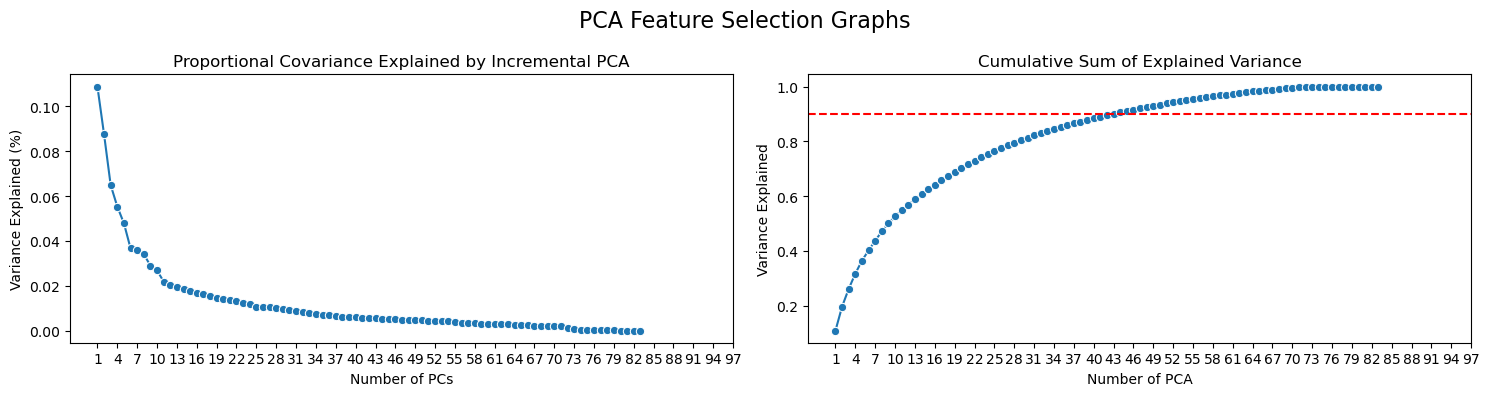

In [17]:
#Graphing N-Components for PCA
fig, ax = plt.subplots(1,2, figsize = (15,4))
fig.suptitle('PCA Feature Selection Graphs', fontsize = 16)
plt.subplot(1,2,1)
prop_variation = sns.lineplot(x = range(1,expl_var.shape[0]+1),y = expl_var,marker='o')
prop_variation.set(title = 'Proportional Covariance Explained by Incremental PCA',xlabel='Number of PCs', ylabel='Variance Explained (%)', xticks = range(1,99,3))

plt.subplot(1,2,2)
cum_variation = sns.lineplot( x = range(1,cumulative_sum.shape[0]+1), y = cumulative_sum, marker='o')
cum_variation.set(title = 'Cumulative Sum of Explained Variance', xlabel ='Number of PCA',ylabel = 'Variance Explained', xticks = range(1,99,3))       
plt.axhline(0.9, c='r', linestyle='--')

plt.tight_layout()
plt.show()

In [18]:
#PCA with Feature Selection
PCA_se = PCA(n_components = .9)
PCA_se= PCA_se.fit(X_train_scaled)
X_train_pca = PCA_se.transform(X_train_scaled)
X_test_pca = PCA_se.transform(X_test_scaled)

pca_formula = PCA_se.components_
print(f'Original: {X_train_scaled.shape}')
print(f'PCA Transformation: {X_train_pca.shape}')

Original: (3838, 83)
PCA Transformation: (3838, 43)


PCA Transformation has converted the original 83 columns of the dataframe to 41

### Data and Variables Summary
Now we have 3 different types of dataset that can be used and tested in models
* **Original Data Variables:** `df`, `x`, `y`
* **Cleaned (non_null) Variables:** `df_cleaned`, `x_cleaned`, `y_cleaned`
* Feature Selection: Decision Tree: `X_feature_selection`, `y_cleaned`
<br>           
<br>  
* Original Data: <br>
            - `X_train`, `y_train` <br>
            - `X_test` , `y_test`
* Scaled Data:  <br>
            - `X_train_scaled` , `y_train_s` <br>
            - `X_test_scaled` ,  `y_test_s` <br>
                         
* Feature Selection: PCA <br>
             - `X_train_PCA` , `y_train_s` <br>
             - `X_test_PCA` , `y_test_s`

## Preliminary Logistic Regression Model <a id = 'statsmodel_logistic_regression'></a>

A preliminary logistic regression is run for the original unscaled data, the scaled data, and the pca data. The results from these will be compared to get a better inclination as to how the model responds to different trasnformations of the data. This will ultimately be helpful in deciding what transformations should be used as the model building process continues.

In [19]:
from sklearn.linear_model import LogisticRegression

As this is a Logistic Regression, additional metrics should be prioritized when evaluating the model rather than the default returned R^2 value. 

The run_log function will report back on a diverse set of metrics in order to make a well rounded analysis: <br>
* Accuracy
* True Positive Rate
* True Negative Rate
* Confusion Matrix
* Recall
* Precision
* F1
* AUC

##### Logisitc Regression Model with Original Data (all features, unscaled)

In [21]:
#Sklearn Logistic Regression with full original dataset
#Run the model
model.run_log(LogisticRegression(), X_train, y_train, results= True)


        Accuracy:                  0.78
        Recall/True Positive Rate: 0.56
        False Positive:            0.12
        AUC Score:                 0.83
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                2283             303
True SNAP                     556             696
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2586
           1       0.70      0.56      0.62      1252

    accuracy                           0.78      3838
   macro avg       0.75      0.72      0.73      3838
weighted avg       0.77      0.78      0.77      3838



(0.7761855132881709,
 0.5559105431309904,
 0.6966966966966966,
 0.6183918258551755,
 0.11716937354988399,
 0.8300479480317956,
 array([0.        , 0.        , 0.        , ..., 0.94431555, 0.94431555,
        1.        ]),
 array([0.00000000e+00, 7.98722045e-04, 7.18849840e-03, ...,
        9.99201278e-01, 1.00000000e+00, 1.00000000e+00]))

##### Logistic Regression Model with Scaled Data (Decision Tree reduced features)

In [22]:
#Sklearn Logistic Regression with Scaled dataset after Decision Tree feature selection
#Run the model
model.run_log(LogisticRegression(), X_train_scaled, y_train, results = True)


        Accuracy:                  0.79
        Recall/True Positive Rate: 0.61
        False Positive:            0.12
        AUC Score:                 0.86
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                2280             306
True SNAP                     486             766
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2586
           1       0.71      0.61      0.66      1252

    accuracy                           0.79      3838
   macro avg       0.77      0.75      0.76      3838
weighted avg       0.79      0.79      0.79      3838



(0.7936425221469515,
 0.6118210862619808,
 0.7145522388059702,
 0.6592082616179002,
 0.11832946635730858,
 0.8624057656241892,
 array([0.       , 0.       , 0.       , ..., 0.9508894, 0.9508894,
        1.       ]),
 array([0.00000000e+00, 7.98722045e-04, 6.38977636e-03, ...,
        9.99201278e-01, 1.00000000e+00, 1.00000000e+00]))

##### Logistic Regression Model with PCA Data

In [23]:
#Sklearn Logistic Regression with Scaled data after Decision Tree Feature Selection
#Run the model
model.run_log(LogisticRegression(),X_train_pca, y_train, results = True)


        Accuracy:                  0.78
        Recall/True Positive Rate: 0.59
        False Positive:            0.12
        AUC Score:                 0.85
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                2269             317
True SNAP                     516             736
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2586
           1       0.70      0.59      0.64      1252

    accuracy                           0.78      3838
   macro avg       0.76      0.73      0.74      3838
weighted avg       0.78      0.78      0.78      3838



(0.7829598749348619,
 0.5878594249201278,
 0.6989553656220323,
 0.6386117136659436,
 0.1225831399845321,
 0.8475506475022795,
 array([0.        , 0.        , 0.        , ..., 0.98878577, 0.98878577,
        1.        ]),
 array([0.00000000e+00, 7.98722045e-04, 1.83706070e-02, ...,
        9.99201278e-01, 1.00000000e+00, 1.00000000e+00]))

### Logistic Regression Comparison
From the results of these 3 Logistic Regressions, the PCA had the lowest all around scores between Accuracy, True Positive Rate, False Positive Rate, AUC Score, and F1 score.

Between the unscaled data and the scaled data, the results show that the scaled data with the feature selection from Decision Trees had slightly better metric scores than the raw data. To continue testing one by one would take a lot of code and a lengthy process. To continue on with model building, a GridSearchCV will be applied to run several models at once and identify the optimal parameter settings for the model to have the highest classification power.

## Linear Hyperparameter Optimization  <a id = 'linear_hyperparameter_optimization'></a>

__Logistic Regression__: Looking for linear relationship <br>
__SVM__: looking for both linear or non-linear relationship
     
Setting up a grid search to iterate through several parameters within linear models in order to identify parameter values that will return the best score metric. The linear gridsearch lies in the `model.py` document. The exact code can be seen there. To get well-rounded and accurate results, several metrics will be considered. The metrics are listed below:
- Recall
- Precision
- F1
- Accuracy
- ROC_AUC

__Model Evaluation__ <br>
Between these 5 metrics that the gridsearch is evaluating on, recall is the highest priority. Given the details of this study, it is prefered to overestimate households that are classified as likely to use SNAP resources rather than underestimate. 

The gridsearch is an extensive program that runs. To ease computation and processing time, the gridsearches have already been executed and the outputs have been combined and saved to the `linear_hyperparameter_optimization` file that is attached with this notebook. The code to activate the gridsearch has been commented out in this notebook to avoid rerunning the extensive code, and the outputs are pulled in from the saved file.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#### Linear Models Optimization: Recall 

In [34]:
#linear_recall = model.linear_gridsearch(logit_X_train, y_train, 'recall')

#### Linear Models Optimization: Accuracy

In [ ]:
#linear_accuracy = model.linear_gridsearch(logit_X_train, y_train, 'accuracy')

#### Linear Models Optimization: Precision

In [35]:
#linear_precision = model.linear_gridsearch(logit_X_train, y_train, 'precision')

#### Linear Models Optimization: F1

In [36]:
#linear_f1 = model.linear_gridsearch(logit_X_train, y_train, 'f1')

#### Linear Models Optimization: ROC_AUC

In [37]:
#linear_auc = model.linear_gridsearch(logit_X_train, y_train, 'roc_auc')

### Linear Model Hyperparameter Summary Table

In [96]:
#combining the outputs from the gridsearch
'''linear_hyperparameter_optimization = pd.concat([linear_accuracy_summary, linear_recall_summary, linear_precision_summary, linear_f1_summary, linear_auc_summary, linear_auc_summary], axis = 0)
linear_hyperparameter_optimization = linear_hyperparameter_optimization.loc[:,['metric_eval','mean_test_score','mean_train_score','param_model', 'param_model__C', 'param_model__penalty','param_model__solver','param_normalize','param_model__kernel','params','rank_test_score']]
linear_hyperparameter_optimization.to_csv('C:/Users/liana.principe/Downloads/linear_hyperparameter_optimization')'''

In [27]:
# importing results from previously run linear gridsearch
linear_optimized_models = pd.read_csv('C:/Users/liana.principe/1. CAPSTONE/SNAP_Utilization/linear_hyperparameter_optimization.csv', sep=",", index_col = 0)
display(linear_optimized_models)

,metric_eval,mean_test_score,mean_train_score,param_model,param_model__C,param_model__penalty,param_model__solver,param_normalize,param_model__kernel,params,rank_test_score
19,accuracy,0.786877,0.797942,LogisticRegression(),1.000,l1,saga,MinMaxScaler(),NaN,"{'model': LogisticRegression(), 'model__C': 1,...",2
25,accuracy,0.784792,0.799505,LogisticRegression(),10.000,l1,saga,MinMaxScaler(),NaN,"{'model': LogisticRegression(), 'model__C': 10...",3
18,accuracy,0.784532,0.800417,LogisticRegression(),1.000,l1,saga,StandardScaler(),NaN,"{'model': LogisticRegression(), 'model__C': 1,...",4
20,accuracy,0.784532,0.800222,LogisticRegression(),1.000,l1,saga,NaN,NaN,"{'model': LogisticRegression(), 'model__C': 1,...",4
34,accuracy,0.784011,0.799375,LogisticRegression(),100.000,l2,saga,MinMaxScaler(),NaN,"{'model': LogisticRegression(), 'model__C': 10...",6
58,accuracy,0.788181,0.834680,SVC(C=1),1.000,NaN,NaN,MinMaxScaler(),rbf,"{'model': SVC(C=1), 'model__C': 1, 'model__ker...",1
57,accuracy,0.782969,0.891089,SVC(C=1),1.000,NaN,NaN,StandardScaler(),rbf,"{'model': SVC(C=1), 'model__C': 1, 'model__ker...",12
59,accuracy,0.782187,0.891024,SVC(C=1),1.000,NaN,NaN,NaN,rbf,"{'model': SVC(C=1), 'model__C': 1, 'model__ker...",20
66,accuracy,0.781143,0.801850,SVC(C=1),100.000,NaN,NaN,StandardScaler(),linear,"{'model': SVC(C=1), 'model__C': 100, 'model__k...",23
60,accuracy,0.780363,0.801004,SVC(C=1),10.000,NaN,NaN,StandardScaler(),linear,"{'model': SVC(C=1), 'model__C': 10, 'model__ke...",25


The first thing to note is that there does not seem to be a large difference between SVC or logistic regression. Both models are able to produce similar metric results with their respective parameters. Continuing forward, logistic regression will be the main linear model.

With Logistic Regression, there is minimal difference between the scaled data and unscaled data. Scaled data will be utilized for final model builing. <br>

Parameters: <br>
C: Various C values across all the metrics. The simpleist value will be used as it also reduces computaion time. <br>
Penalty: L1 penalty is slightly more common in the summary results output <br>
Solver: The solver should be saga <br>

## Non-Linear Hyperparameter Optimization <a id = 'nonlinear_hyperparameter_optimization'></a>

__XGBoost__: Non-linear Classification<br>

A similar process to identify the model that optimizes score results is conducted for the Boosted Random Forest model. The gridsearch will iterate through a Boosted Random Forest model and will identify the specific parameters that optimize the scoring metric specified. The metrics considered when evaluate for non-linear hyperparameter is the same as before (recall, precision, F1, Accuracy, ROC-AUC). The exact code to run the non-linear hyperparameter optimization lies in the `model.py` document which is attached with this notebook. An exact detailing of the code can be viewed in that data file. 

__Model Evaluation__ <br>
For a Random Forest, ROC Curve and Recall will be the highest metrics considered. While recall remains to be the primary metric of evaluation, a high ROC_AUC score indicates that recall can be optimized without sacrificing or offsetting precision. This relationship will be taken into consideration.

The gridsearch for Boosted Random Forests have already been run, and the output has been saved to the `XGB_RF_utilization_optimized_models` file that is attached with this notebook. The code to activate the gridsearch has been commented out in this notebook to avoid rerunning the extensive code, and the outputs are pulled in from the saved file.

### XGBoost

In [29]:
from xgboost import XGBClassifier
import pickle

#### Non- Linear Models Optimization: Recall

In [42]:
#rf_recall = model.boost_tree(X_train_scaled, y_train, 'recall')

#### Non-Linear Models Optimization: ROC

In [41]:
#rf_roc = model.boost_tree(X_train_scaled, y_train, 'roc_auc')

#### Non-Linear Models Optimization: Accuracy

In [40]:
#rf_accuracy = model.boost_tree(X_train_scaled, y_train, 'accuracy')

#### Non-Linear Models Optimization: F1

In [43]:
#rf_f1 = model.boost_tree(X_train_scaled, y_train, 'f1')

In [32]:
#Combining all the XGBoost Hyperaparemeter Tuning Outputs into a dataframe
'''rf_hyperparameter_optimization = pd.concat([rf_roc, rf_recall, rf_accuracy, rf_f1], axis = 0)
rf_hyperparameter_optimization = rf_hyperparameter_optimization.loc[:,['mean_test_score','metric_eval','param_booster','param_learning_rate','param_max_depth','param_n_estimators','params','rank_test_score']]

In [33]:
# saving the output of the results from the SGBoost into an object with pickeling
'''with open('XGB_RF_utilization_optimized_models','wb')as boosted_tree_results:
    pickle.dump(rf_hyperparameter_optimization, boosted_tree_results)'''

In [30]:
# retrieving the non-linear gridsearch
with open('XGB_RF_utilization_optimized_models', 'rb') as boosted_tree_results:
    rf_optimized_models = pickle.load(boosted_tree_results)
display(rf_optimized_models)

,mean_test_score,metric_eval,param_booster,param_learning_rate,param_max_depth,param_n_estimators,params,rank_test_score
208,0.871612,roc_auc,dart,0.1,2,150,"{'booster': 'dart', 'learning_rate': 0.1, 'max...",1
58,0.871612,roc_auc,gbtree,0.1,2,150,"{'booster': 'gbtree', 'learning_rate': 0.1, 'm...",1
209,0.871517,roc_auc,dart,0.1,2,180,"{'booster': 'dart', 'learning_rate': 0.1, 'max...",3
59,0.871517,roc_auc,gbtree,0.1,2,180,"{'booster': 'gbtree', 'learning_rate': 0.1, 'm...",3
62,0.870817,roc_auc,gbtree,0.1,3,100,"{'booster': 'gbtree', 'learning_rate': 0.1, 'm...",5
260,0.648555,recall,dart,0.5,3,20,"{'booster': 'dart', 'learning_rate': 0.5, 'max...",1
110,0.648555,recall,gbtree,0.5,3,20,"{'booster': 'gbtree', 'learning_rate': 0.5, 'm...",1
126,0.646167,recall,gbtree,0.5,6,50,"{'booster': 'gbtree', 'learning_rate': 0.5, 'm...",3
276,0.646167,recall,dart,0.5,6,50,"{'booster': 'dart', 'learning_rate': 0.5, 'max...",3
101,0.644561,recall,gbtree,0.5,1,50,"{'booster': 'gbtree', 'learning_rate': 0.5, 'm...",5


#### Non-Linear Hyperparameter Analysis
The results from the random boosted tree provide the top 5 models that produce the same maximum recall score, giving several options for the 'best model' to continue into the model building stage. 

The returned output also shows almost no difference between gbtree or dart. gbtree will be chosen for faster computing time. <br>
Prefered learning rate: .1 or .5 <br>
Prefered max_depth: 2 or 3. Any  more will lead to overfitting <br>
Prefered n_estimators: lower n_estimators for recall, higher n_estimators for auc

## Model Building <a id = 'model_building'> </a>

Now that the optimized parameters and models have been identified, the next step is to run the data through the models collected in the gridsearch. The scaled data will be instantiated and fit through the logistic regression and boosted random forest models. Additionally, their feature importance will also be assessed.

#### Logistic Regression Model <a id = 'model_assessment'> </a>

In [31]:
logit_optimized = LogisticRegression(C = 1, penalty = 'l1', solver = 'saga').fit(X_train_scaled, y_train)
model.run_log(logit_optimized, X_train_scaled, y_train, results = True)


        Accuracy:                  0.80
        Recall/True Positive Rate: 0.62
        False Positive:            0.12
        AUC Score:                 0.86
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                2281             305
True SNAP                     478             774
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2586
           1       0.72      0.62      0.66      1252

    accuracy                           0.80      3838
   macro avg       0.77      0.75      0.76      3838
weighted avg       0.79      0.80      0.79      3838



(0.7959874934861907,
 0.6182108626198083,
 0.7173308619091752,
 0.6640926640926641,
 0.11794276875483373,
 0.8637981240842185,
 array([0.        , 0.        , 0.        , ..., 0.94199536, 0.94199536,
        1.        ]),
 array([0.00000000e+00, 7.98722045e-04, 6.38977636e-03, ...,
        9.99201278e-01, 1.00000000e+00, 1.00000000e+00]))

#### Logistic Regression Feature Importance

In [32]:
logit_fi = pd.DataFrame({'feature': X_feature_selection.columns,'odds_ratio': [np.exp(feat_imp) for sublist in logit_optimized.coef_ for feat_imp in sublist]})
display(logit_fi.sort_values('odds_ratio'))

,feature,odds_ratio
7,pctpovguidehh_r,0.000058
30,exphealthins_r,0.056518
23,exprentmrtg_r,0.112207
18,liqassets,0.204774
20,vehiclenum,0.335409
80,ndinnersouthh,0.368341
25,expproptax_r,0.381624
8,inchhreported_r,0.398962
22,largeexp,0.620783
19,anyvehicle,0.729772


After running the data through the optimized logistic regression, the smalles odds ratio is pctpovguidehh_r. This could be considered to remove in the future.

#### Boosted Random Forest Model

In [33]:
rf_optimized = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 3, n_estimators = 150,n_jobs=1).fit(X_train_scaled, y_train)
model.run_log(rf_optimized, X_train_scaled, y_train, results = True)


        Accuracy:                  0.86
        Recall/True Positive Rate: 0.75
        False Positive:            0.09
        AUC Score:                 0.94
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                2346             240
True SNAP                     313             939
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2586
           1       0.80      0.75      0.77      1252

    accuracy                           0.86      3838
   macro avg       0.84      0.83      0.83      3838
weighted avg       0.85      0.86      0.85      3838



(0.8559145388223033,
 0.75,
 0.7964376590330788,
 0.7725215960510078,
 0.09280742459396751,
 0.9356253505605262,
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.86697602e-04,
        3.86697602e-04, 7.73395205e-04, 7.73395205e-04, 1.16009281e-03,
        1.16009281e-03, 1.54679041e-03, 1.54679041e-03, 1.93348801e-03,
        1.93348801e-03, 2.32018561e-03, 2.32018561e-03, 2.70688322e-03,
        2.70688322e-03, 3.09358082e-03, 3.09358082e-03, 3.86697602e-03,
        3.86697602e-03, 4.25367363e-03, 4.25367363e-03, 4.64037123e-03,
        4.64037123e-03, 5.02706883e-03, 5.02706883e-03, 5.41376643e-03,
        5.41376643e-03, 5.80046404e-03, 5.80046404e-03, 6.18716164e-03,
        6.18716164e-03, 6.57385924e-03, 6.57385924e-03, 6.96055684e-03,
        6.96055684e-03, 7.34725445e-03, 7.34725445e-03, 8.12064965e-03,
        8.12064965e-03, 8.50734725e-03, 8.50734725e-03, 8.89404486e-03,
        8.89404486e-03, 9.28074246e-03, 9.28074246e-03, 9.66744006e-03,
        9.66744006e-03,

#### Boosted Random Forest Feature Importance

In [34]:
rf_fi= pd.DataFrame({'feature': X_feature_selection.columns,'feature_importance': rf_optimized.feature_importances_})
rf_fi.sort_values('feature_importance')

,feature,feature_importance
53,shopbigbox,0.000000
63,farmersmarket,0.000000
64,huntfish,0.000000
21,caraccess,0.000000
69,allergyegg,0.000000
70,allergyshellfish,0.000000
14,earnsamenum,0.000000
13,earnmorenum_r,0.000000
10,selfemployfoodhh,0.000000
56,shopbakery,0.000000


### Model Comparison
The Boosted Random Forest produces better results across all metrics. A higher Accuracy, Recall, AUC Score, F1 and a lower False Positive. Additionally, in the Classification matrix, there are more True Positives calculated. While the  boosted random forest has higher metrics, it is still valuable to continue the data with the logistic regression for further comparison as the study continues.

The next step of this research is to experiment with different levels of the threshold

## Threshold Tampering <a id = 'threshold_tampering'> </a>

Now that the optimized models have been identified, the thresholds can be altered to improve specific model evaluation metrics. As stated earlier, the analysis in this study is choosing to focus on recall as the primary metric when picking a model. Other metrics are included for consideration. By adjusting the threshold, this will affect how the classifier makes a final decision between 0 or 1, or in the case of this study, classifying a household that does not use SNAP resources vs. a household that does.

The function "metric_graph" lies in the `model.py` document but is used in this notebook to plot the recall, precision, f1, and AUC metric score for each threshold value between (0-1). The resulting graphs from the formula will help visualize what threshold value can optimize the recall score without sacrificing the vaues of the other metrics. These plots are integral in deciding what threshold to set the optimized models to in order to improve overall model performance. 

##### Optimized Logistic Regresion Model Run with default Threshold

In [35]:
logit_optimized = LogisticRegression(C = 1, penalty = 'l1', solver = 'saga').fit(X_train_scaled, y_train)
model.run_log(logit_optimized, X_train_scaled, y_train, threshold = .5, results = True)


        Accuracy:                  0.80
        Recall/True Positive Rate: 0.62
        False Positive:            0.12
        AUC Score:                 0.86
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                2281             305
True SNAP                     478             774
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2586
           1       0.72      0.62      0.66      1252

    accuracy                           0.80      3838
   macro avg       0.77      0.75      0.76      3838
weighted avg       0.79      0.80      0.79      3838



(0.7959874934861907,
 0.6182108626198083,
 0.7173308619091752,
 0.6640926640926641,
 0.11794276875483373,
 0.8637996684037172,
 array([0.        , 0.        , 0.        , ..., 0.94199536, 0.94199536,
        1.        ]),
 array([0.00000000e+00, 7.98722045e-04, 6.38977636e-03, ...,
        9.99201278e-01, 1.00000000e+00, 1.00000000e+00]))

##### Optimized Random Forest Model Run with default Threshold

In [32]:
rf_optimized = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 3, n_estimators = 150,n_jobs=1).fit(X_train_scaled, y_train)
model.run_log(rf_optimized, X_train_scaled, y_train, results = True)


        Accuracy:                  0.86
        Recall/True Positive Rate: 0.75
        False Positive:            0.09
        AUC Score:                 0.93
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                2360             226
True SNAP                     311             941
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      2586
           1       0.81      0.75      0.78      1252

    accuracy                           0.86      3838
   macro avg       0.84      0.83      0.84      3838
weighted avg       0.86      0.86      0.86      3838



(0.8600833767587285,
 0.7515974440894568,
 0.8063410454155956,
 0.77800744109136,
 0.08739365815931942,
 0.9349890909270612,
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.86697602e-04,
        3.86697602e-04, 7.73395205e-04, 7.73395205e-04, 1.16009281e-03,
        1.16009281e-03, 1.54679041e-03, 1.54679041e-03, 1.93348801e-03,
        1.93348801e-03, 2.32018561e-03, 2.32018561e-03, 2.70688322e-03,
        2.70688322e-03, 3.09358082e-03, 3.09358082e-03, 3.48027842e-03,
        3.48027842e-03, 3.86697602e-03, 3.86697602e-03, 4.25367363e-03,
        4.25367363e-03, 4.64037123e-03, 4.64037123e-03, 5.02706883e-03,
        5.02706883e-03, 5.41376643e-03, 5.41376643e-03, 5.80046404e-03,
        5.80046404e-03, 6.18716164e-03, 6.18716164e-03, 6.96055684e-03,
        6.96055684e-03, 7.34725445e-03, 7.34725445e-03, 7.73395205e-03,
        7.73395205e-03, 8.12064965e-03, 8.12064965e-03, 8.89404486e-03,
        8.89404486e-03, 9.28074246e-03, 9.28074246e-03, 1.00541377e-02,
        1.0

#### Threshold Plotting for Logistic Regression

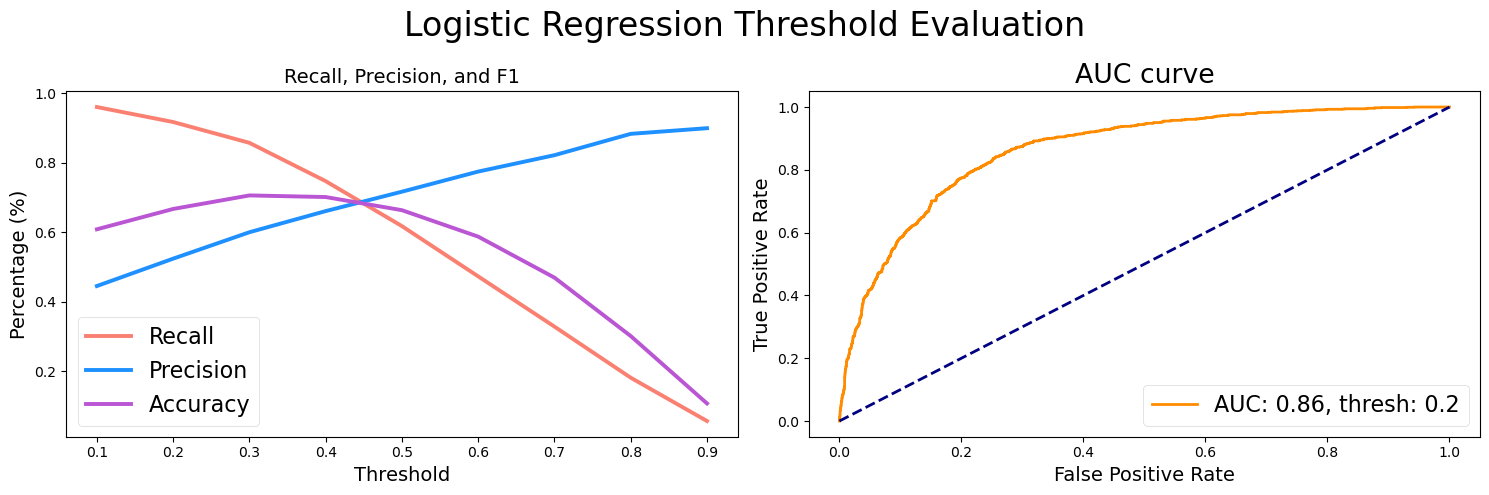

In [36]:
model.metric_graph('Logistic Regression',logit_optimized, X_train_scaled, y_train)

Keeping in mind that the primary metric is recall, the best threshold value for logistic regression appears to be at a value of 0.3. The lower the threshold the higher the recall, so the decision must also consider the other metrics. By moving from a threshold of 0.2 to 0.3, both the accuracy and precision increase in the model, whle the threshold has a marginal dip. Additionally, the AUC is still very high at both a 0.2 threshold and a 0.3 threshold. It is recommended to set the threshold for 0.3 for the logistic model

#### Threshold Plotting for Boosted Random Forest

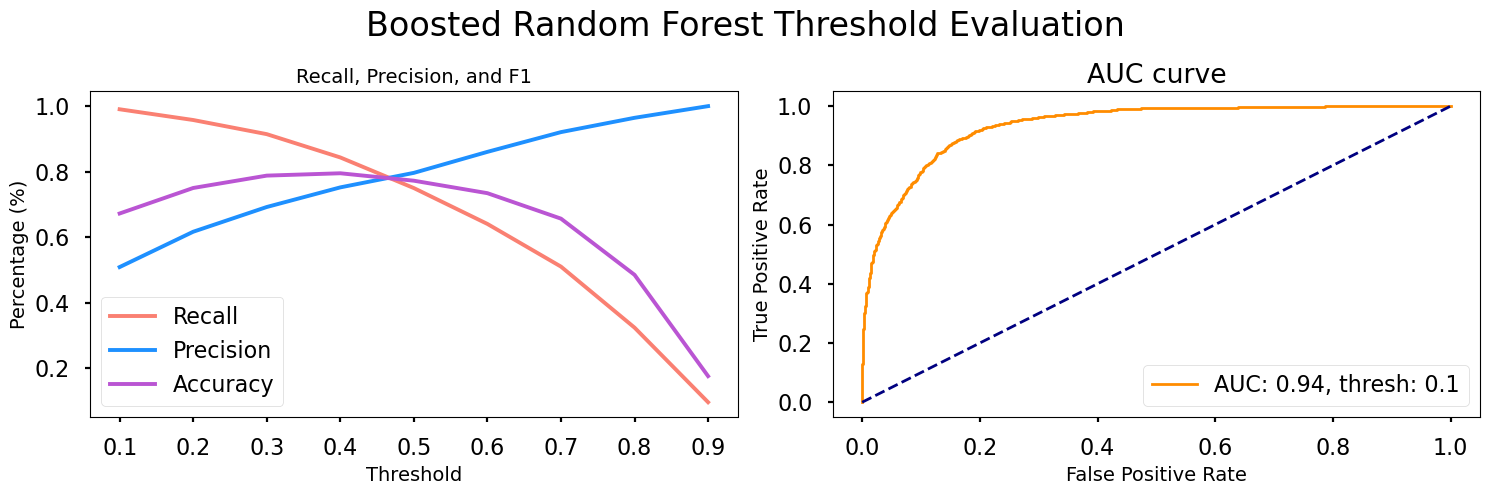

In [37]:
model.metric_graph('Boosted Random Forest',rf_optimized, X_train_scaled, y_train)

For a boosted random forest, there is a clear convergence of all the metrics at a threshold of 0.5. Although all these metrics convege at this point, this does not indicate that this is the threshold value that will most optimize model performance. The accuracy sees marginal difference when the threshold is between (0.2 - 0.5), giving a wide window of performance for accuracy. The next thing to consider is the relationship between recall and precision. While recall is the main priority, precision and accuracy should also be at a sufficient level. When the threshold has a value of 0.3, this is where recall is still performing above 80%, and accuracy and precision are sufficiently high. Similarly, the AUC curve at that value is sufficiently high.

## Final Training Models <a id = 'final_model_analysis'> </a>

Through all the steps of feature selection, hyperparameter tuning, and threshold tampering, the final models have been selected and can be run one last time on the training data.

In [42]:
logit_optimized = LogisticRegression(C = 1, penalty = 'l1', solver = 'saga').fit(X_train_scaled, y_train)
model.run_log(logit_optimized, X_train_scaled, y_train, threshold = .3, results = True)


        Accuracy:                  0.77
        Recall/True Positive Rate: 0.86
        False Positive:            0.28
        AUC Score:                 0.86
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                1872             714
True SNAP                     178            1074
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      2586
           1       0.60      0.86      0.71      1252

    accuracy                           0.77      3838
   macro avg       0.76      0.79      0.76      3838
weighted avg       0.81      0.77      0.77      3838



(0.7675872850442939,
 0.8578274760383386,
 0.6006711409395973,
 0.706578947368421,
 0.27610208816705334,
 0.8638018304510154,
 array([0.        , 0.        , 0.        , ..., 0.94199536, 0.94199536,
        1.        ]),
 array([0.00000000e+00, 7.98722045e-04, 6.38977636e-03, ...,
        9.99201278e-01, 1.00000000e+00, 1.00000000e+00]))

In [54]:
rf_optimized = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 3, n_estimators = 150,n_jobs=1).fit(X_train_scaled, y_train)
model.run_log(rf_optimized, X_train_scaled, y_train, threshold = .3,results = True)


        Accuracy:                  0.84
        Recall/True Positive Rate: 0.91
        False Positive:            0.20
        AUC Score:                 0.94
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                2077             509
True SNAP                     107            1145
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      2586
           1       0.69      0.91      0.79      1252

    accuracy                           0.84      3838
   macro avg       0.82      0.86      0.83      3838
weighted avg       0.87      0.84      0.84      3838



(0.839499739447629,
 0.9145367412140575,
 0.6922611850060459,
 0.7880247763248451,
 0.1968290796597061,
 0.9356253505605262,
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.86697602e-04,
        3.86697602e-04, 7.73395205e-04, 7.73395205e-04, 1.16009281e-03,
        1.16009281e-03, 1.54679041e-03, 1.54679041e-03, 1.93348801e-03,
        1.93348801e-03, 2.32018561e-03, 2.32018561e-03, 2.70688322e-03,
        2.70688322e-03, 3.09358082e-03, 3.09358082e-03, 3.86697602e-03,
        3.86697602e-03, 4.25367363e-03, 4.25367363e-03, 4.64037123e-03,
        4.64037123e-03, 5.02706883e-03, 5.02706883e-03, 5.41376643e-03,
        5.41376643e-03, 5.80046404e-03, 5.80046404e-03, 6.18716164e-03,
        6.18716164e-03, 6.57385924e-03, 6.57385924e-03, 6.96055684e-03,
        6.96055684e-03, 7.34725445e-03, 7.34725445e-03, 8.12064965e-03,
        8.12064965e-03, 8.50734725e-03, 8.50734725e-03, 8.89404486e-03,
        8.89404486e-03, 9.28074246e-03, 9.28074246e-03, 9.66744006e-03,
        9.6

### Final Training Model Analysis 

By reducing the threshold for binary logistic regression classifiers to .3, the Recall has increased by almost 20% to a maximum of 86% Recall. On the contrary, precision has decreased by 10% with the new model and currently lies at 60% which means that of the people who the model identifies as SNAP households, the model is correct 60% of the time. This is reiterated with an increase in False positives rate which nearly doubles from 12% to be 27%. A higher false positive rate means that the model will identify households who do not utilize SNAP benefits 27% of the time. An increase in recall typically comes at the cost of a decrease in precision. In this study, recall is one of the primary objectives and is regarded higher than precision. 

It is more beneficial to wrongfully classify a house as likely to use SNAP benefits rather than overlook and miss a house that is likely to use SNAP benefits. For that reason, recall is the prioritized evaluation metric in this section of study.

Between this oscilating balance of recall and precision, it is worthwhile to note that the F1 score has also increased from 62% to 71%. Overall accuracy of the model, the ability to predict SNAP households and non-SNAP households correctly has decreased only slightly and is now 77% accurate. Including a higher recall, 77% is a fine 


The AUC score hasn't changed greatly.

By reducing the threshold for the boosted random forest model, the recall has also increased by nearly 20% and is recorded at 91, the highest that has been seen so far. With this increase in recall came a .2 decrease in accuracy, a .2 decrease in precision, and the false positive rate has doubled. As stated earlier, a slightly higher false positive rate is not too concerning for this study. Overall, the model is able to correctly predict more households that used SNAP resources.

Similar to the logistic regression model, he f1 score and the AUC score have not changed greatly. 

Now that the final models have been created and tested on the training dataset, the next step is to test it on the testing dataset. 

## Testing and Results <a id = 'final_test'> </a>

The process with testing the models includes

#### Logistic Regression Test

In [56]:
#using the optimized logistical model that was previously instantiated, create predictions
ytest_pred = logit_optimized.predict_proba(X_test_scaled)[:,1]
ytest_pred_binary = np.where(ytest_pred>.3,1,0)
#Accuracy
logit_accuracy = model.accuracy_score(y_test, ytest_pred_binary)
logit_cf_matrix = model.confusion_matrix(y_test, ytest_pred_binary)
logit_cf_df = pd.DataFrame(logit_cf_matrix,               
                        columns=["Predicted Non-SNAP", "Predicted SNAP"],
                        index=["True Non-SNAP", "True SNAP"]) # label rows and columns
model.ConfusionMatrixDisplay(confusion_matrix = logit_cf_matrix)
logit_class_report = model.classification_report(y_test, ytest_pred_binary)
logit_class_report_dict = model.classification_report(y_test, ytest_pred_binary, output_dict = True)
logit_recall = logit_class_report_dict['1']['recall'] 
logit_precision = logit_class_report_dict['1']['precision']
logit_f1 = logit_class_report_dict['1']['f1-score']
logit_false_pos_rate = model.false_positive_rate(y_test, ytest_pred_binary)
logit_roc_auc = model.roc_auc_score(y_test, ytest_pred)
print( '''
        Accuracy:                  {:.2f}
        Recall/True Positive Rate: {:.2f}
        False Positive:            {:.2f}
        AUC Score:                 {:.2f}
        {}'''.format(logit_accuracy, logit_recall ,logit_false_pos_rate, logit_roc_auc, divider))
print(f'{logit_cf_df}\n{divider}\n{logit_class_report}')


        Accuracy:                  0.76
        Recall/True Positive Rate: 0.84
        False Positive:            0.28
        AUC Score:                 0.87
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                 458             180
True SNAP                      50             272
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       638
           1       0.60      0.84      0.70       322

    accuracy                           0.76       960
   macro avg       0.75      0.78      0.75       960
weighted avg       0.80      0.76      0.77       960



In [79]:
logit_feature_importance = pd.DataFrame({'feature': X_feature_selection.columns,'feature_importance': [np.exp(feat_imp) for sublist in logit_optimized.coef_ for feat_imp in sublist]})
print('Top 10 features in Logistic Regression Model')
logit_feature_importance.sort_values('feature_importance', ascending = False, inplace = True)
logit_feature_importance.head(10)

Top 10 features in Logistic Regression Model


,feature,feature_importance
3,hhsize,26.893620
17,housingsub,4.348792
73,anytobacco,3.806709
16,housingpub,3.678959
81,nmealshome,2.156386
57,shopmeatfish,2.000398
37,anypregnant,1.873814
82,nmealstogether,1.805279
36,schservebrkfst,1.548317
77,utilnotpaid6mos,1.469977


#### Boosted Random Forest Test

In [57]:
#using the optimized logistical model that was previously instantiated, create predictions
ytest_pred = rf_optimized.predict_proba(X_test_scaled)[:,1]
ytest_pred_binary = np.where(ytest_pred>.3,1,0)
#Accuracy
logit_accuracy = model.accuracy_score(y_test, ytest_pred_binary)
logit_cf_matrix = model.confusion_matrix(y_test, ytest_pred_binary)
logit_cf_df = pd.DataFrame(logit_cf_matrix,               
                        columns=["Predicted Non-SNAP", "Predicted SNAP"],
                        index=["True Non-SNAP", "True SNAP"]) # label rows and columns
model.ConfusionMatrixDisplay(confusion_matrix = logit_cf_matrix)
logit_class_report = model.classification_report(y_test, ytest_pred_binary)
logit_class_report_dict = model.classification_report(y_test, ytest_pred_binary, output_dict = True)
logit_recall = logit_class_report_dict['1']['recall'] 
logit_precision = logit_class_report_dict['1']['precision']
logit_f1 = logit_class_report_dict['1']['f1-score']
logit_false_pos_rate = model.false_positive_rate(y_test, ytest_pred_binary)
logit_roc_auc = model.roc_auc_score(y_test, ytest_pred)
print( '''
        Accuracy:                  {:.2f}
        Recall/True Positive Rate: {:.2f}
        False Positive:            {:.2f}
        AUC Score:                 {:.2f}
        {}'''.format(logit_accuracy, logit_recall ,logit_false_pos_rate, logit_roc_auc, divider))
print(f'{logit_cf_df}\n{divider}\n{logit_class_report}')


        Accuracy:                  0.79
        Recall/True Positive Rate: 0.82
        False Positive:            0.23
        AUC Score:                 0.88
               Predicted Non-SNAP  Predicted SNAP
True Non-SNAP                 491             147
True SNAP                      57             265
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       638
           1       0.64      0.82      0.72       322

    accuracy                           0.79       960
   macro avg       0.77      0.80      0.78       960
weighted avg       0.81      0.79      0.79       960



##### Non-linear Feature importance

In [78]:
non_lin_feature_importance = pd.DataFrame({'feature': X_feature_selection.columns,'feature_importance': rf_optimized.feature_importances_})
print('Top 10 features to Predict SNAP HH Usage')
non_lin_feature_importance.sort_values('feature_importance', ascending = False, inplace = True)
non_lin_feature_importance.head(10)

Top 10 features to Predict SNAP HH Usage


,feature,feature_importance
7,pctpovguidehh_r,0.183549
18,liqassets,0.072669
30,exphealthins_r,0.032846
73,anytobacco,0.029354
77,utilnotpaid6mos,0.028600
36,schservebrkfst,0.022539
43,primstoretravelmode,0.021174
3,hhsize,0.020524
23,exprentmrtg_r,0.018277
25,expproptax_r,0.017925


### Final Feature Importance <a id = 'final_feature_importance'> </a>

[Text(0.5, 1.0, 'Top 10 features in Logistic Model'),
 Text(0.5, 0, 'Odds Ratio')]

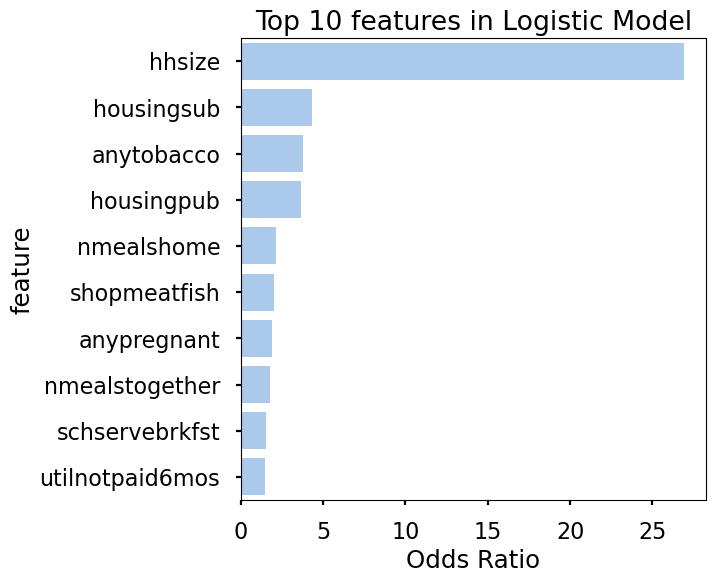

In [83]:
#Logistic Feature Importance
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
sns.barplot(x="feature_importance", y="feature", data=logit_feature_importance.head(10),orient = 'h', color="b").set(title = 'Top 10 features in Logistic Model', xlabel = 'Odds Ratio')

[Text(0.5, 1.0, 'Top 10 features in Bosted Random Forest Model')]

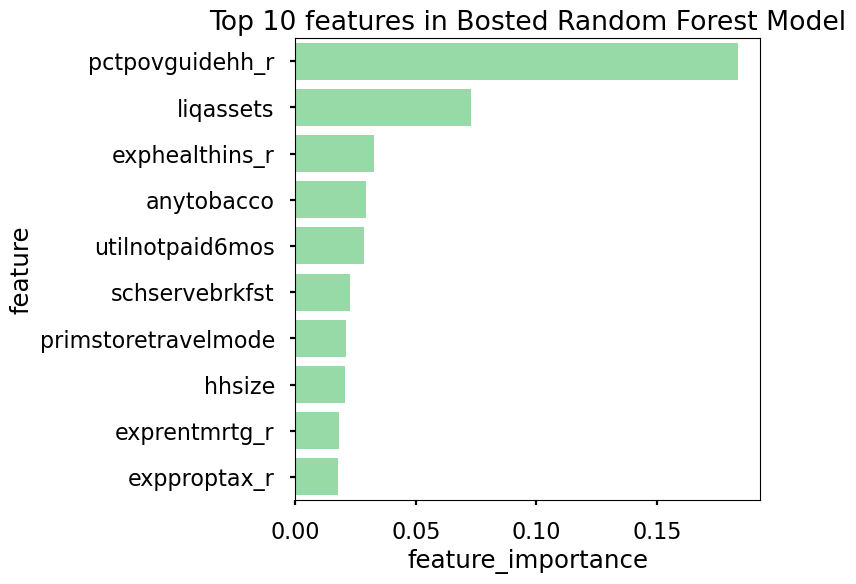

In [87]:
# Boosted Random Forest featur eImportance
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
sns.barplot(x="feature_importance", y="feature", data=non_lin_feature_importance.head(10),orient = 'h', color="g").set(title = 'Top 10 features in Bosted Random Forest Model')

### Final Test Analysis

With the final test run, both have a recall over 80%, although the recall from the logistic regression is slightly higher, despite the boosted random forest performing better throughout nearly the whole process. This might be an indication of slight overfitting, which should be reviewed. When consdiering the other evaluatoin metrics, the boosted random forest model does perform better than the logistic model, although  the logistic model is able to correctly classify 7 more households than the boosted random forest.

When looking at the top 10 features for each model, there is a slight overlap between the two, although the majority of them are different. In future iterations, more models can be used to increase performance and results. Additionally, more in depth feature selection can be performed to better understand the relationships that each feature  may have with the likelihood of a household to utilize SNAP benefits.